In [1]:
!pip install plotly==4.14.3 chart_studio cufflinks pandas joblib

In [17]:
%load_ext autoreload
%autoreload 2

import plotly

import chart_studio.plotly as py
from  plotly.offline import iplot
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()

import pandas as pd
import numpy as np
import glob
import random
from sklearn import preprocessing

# Make sure we are running Python 3
import sys
print(sys.version)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]


In [40]:
FOLDER_NAMES = ["cross", "hook", "negative"]
GESTURES = ["cross", "hook", "negative_trim"]

# Manually determined trims (copied from Google Sheets)
TRIMS = pd.read_csv('trim_ms.csv', header=0, index_col=0, squeeze=True)
TRIMS = pd.to_numeric(TRIMS, errors='coerce').to_dict()

SEGMENT_LEN_MS = 1490
SAMPLE_FREQ_HZ = 120
SEGMENT_LEN = int(SEGMENT_LEN_MS / SAMPLE_FREQ_HZ * 10) - 5

In [41]:
min_max_scaler = preprocessing.MinMaxScaler()

def read_data(folder_name):
    traces = []
    trace_names = []
    for f in sorted(glob.glob(folder_name + "/*.csv")):
        print(f)
        filename = f[f.find('/') + 1:-4]
        trace = pd.read_csv(f, header=0, index_col="time_ms")
        print(trace.shape)
        trace = trace.apply(pd.to_numeric, errors='coerce')
        trace["accel"] = np.linalg.norm((trace["aX"], trace["aY"], trace["aZ"]), axis=0)
        trace["gyro"] = np.linalg.norm((trace["gX"], trace["gY"], trace["gZ"]), axis=0)
        
        
        normalized = min_max_scaler.fit_transform(trace['aZ'].values.reshape(-1, 1))
        normalized = normalized[:, 0]
        trace["normalized_accel_z"] = normalized
        
        trace_names.append(filename)
        traces.append(trace)
    return trace_names, traces
        
traces = {}
trace_names = {}
for folder_name in FOLDER_NAMES:
    trace_names[folder_name], traces[folder_name] = read_data(folder_name)

cross/cross001.csv
(169, 8)
cross/cross002.csv
(169, 8)
cross/cross003.csv
(170, 8)
cross/cross004.csv
(169, 8)
cross/cross005.csv
(169, 8)
cross/cross006.csv
(169, 8)
cross/cross007.csv
(160, 8)
cross/cross008.csv
(169, 8)
cross/cross009.csv
(169, 8)
cross/cross010.csv
(169, 8)
cross/cross011.csv
(169, 8)
cross/cross012.csv
(169, 8)
cross/cross013.csv
(169, 8)
cross/cross014.csv
(169, 8)
cross/cross015.csv
(169, 8)
cross/cross016.csv
(170, 8)
cross/cross017.csv
(169, 8)
cross/cross018.csv
(169, 8)
cross/cross019.csv
(169, 8)
cross/cross020.csv
(169, 8)
cross/cross021.csv
(170, 8)
cross/cross022.csv
(169, 8)
cross/cross023.csv
(170, 8)
cross/cross024.csv
(169, 8)
cross/cross025.csv
(169, 8)
cross/cross026.csv
(169, 8)
cross/cross027.csv
(169, 8)
cross/cross028.csv
(170, 8)
cross/cross029.csv
(170, 8)
cross/cross030.csv
(170, 8)
cross/cross031.csv
(170, 8)
cross/cross032.csv
(170, 8)
cross/cross033.csv
(171, 8)
cross/cross034.csv
(170, 8)
cross/cross035.csv
(170, 8)
cross/cross036.csv
(

In [42]:
# Split the long negative traces in 1.5 second segments
traces["negative_trim"] = []
trace_names["negative_trim"] = []
for i, trace in enumerate(traces["negative"]):
    for j in range(0, len(trace), 500):
        # Pad an extra 10 to make sure are generous with data points
        traces["negative_trim"].append(trace[j:j + SEGMENT_LEN_MS + 10])
        trace_names["negative_trim"].append(trace_names["negative"][i] + '_' + str(j))

In [43]:
# Trim traces
for gesture in GESTURES:
    for i, trace in enumerate(traces[gesture]):
        filename = trace_names[gesture][i]
        
        if filename in TRIMS:
            trim = TRIMS[filename]  
            if np.isnan(trim) or trim < SEGMENT_LEN_MS:
                print('DROPPING TRACE', filename, 'TRIM IS TOO EARLY / BLACKLISTED')
                del traces[gesture][i]
                del trace_names[gesture][i]
                continue
            trim += random.randrange(0, 200)
            trace = trace[trim - SEGMENT_LEN_MS:trim]
            
        if len(trace) < SEGMENT_LEN:
            print('DROPPING TRACE', filename, 'NOT ENOUGH DATA POINTS')
            del traces[gesture][i]
            del trace_names[gesture][i]
            continue
            
        traces[gesture][i] = trace.iloc[len(trace) - SEGMENT_LEN:]
        print(filename)
        trace.index = trace.index - trace.index[0]
        traces[gesture][i] = trace

cross001
cross002
cross003
cross004
cross005
cross006
cross007
cross008
cross009
cross010
cross011
cross012
cross013
cross014
cross015
cross016
cross017
cross018
cross019
cross020
cross021
cross022
cross023
cross024
cross025
cross026
cross027
cross028
cross029
cross030
cross031
cross032
cross033
cross034
cross035
cross036
cross037
cross038
cross039
cross040
cross041
cross042
cross043
cross044
cross045
cross046
cross047
cross048
cross049
cross050
cross051
cross052
cross053
cross054
cross055
cross056
cross057
cross058
cross059
cross060
cross061
cross062
cross063
cross064
cross065
cross066
cross067
cross068
cross069
cross070
cross071
cross072
cross073
cross074
cross075
cross076
cross077
cross078
cross079
cross080
cross081
cross082
cross083
cross084
cross085
cross086
cross087
cross088
cross089
cross090
hook001
hook002
hook003
hook004
hook005
hook006
hook007
hook008
hook009
hook010
hook011
hook012
hook013
hook014
hook015
hook016
hook017
hook018
hook019
hook020
hook021
hook022
hook023
hook02

In [44]:
print(traces["cross"][0].columns)

Index(['Unnamed: 0', 'delta_ms', 'aX', 'aY', 'aZ', 'gX', 'gY', 'gZ', 'accel',
       'gyro', 'normalized_accel_z'],
      dtype='object')


In [45]:
SENSORS_LIST = ["aX", "aY", "aZ"]
# SENSORS_LIST = ["gyro_degs_x", "gyro_degs_y", "gyro_degs_z"]
# SENSORS_LIST = ["accel"]
SENSORS_LIST = ["normalized_accel_z"]
def plot_all(gesture, large=False):
    for i, trace in enumerate(traces[gesture]):
        data = [] 
        annotations = []
        for sensor in SENSORS_LIST:
            data.append(go.Scatter(
                x = trace.index,
                y = trace[sensor],
                name = sensor,
                line = dict(width = 4 if large else 1)))
            
#             annotations.append(dict(xref='paper', x=1, y=trace[sensor].iloc[-1],
#                                   xanchor='left', yanchor='middle',
#                                   text=sensor,
#                                   showarrow=False))
        layout = go.Layout(
            title = trace_names[gesture][i],
            annotations = annotations,
            font=dict(size=28 if large else 8),
            width=1000,
            margin=go.layout.Margin(r=200, pad=5),
            xaxis = dict(title='Time (ms)'))
            #showlegend=False,
            #yaxis = dict(range=[0, 25])
            #              )
        iplot({'data': data, 'layout': layout}, filename='jupyter-basic_bar')

In [11]:
#plot_all("cross")

In [46]:
import utils

print(utils)

def get_all_features(trace, generate_feature_names=False):
    features = utils.get_model_features(trace, generate_feature_names)
    
    if generate_feature_names:
        features.append('accel_z_peaks')
    else:
        normalized = min_max_scaler.fit_transform(trace['normalized_accel_z'].values.reshape(-1, 1))[:, 0] # normalize
        normalized = normalized[0:len(normalized):5] # subsample
        normalized = np.diff((normalized > 0.77).astype(int)) # convert to binary classifier
        normalized = normalized[normalized>0]
        features.append(sum(normalized))
    
    return features

<module 'utils' from '/home/ken/Desktop/Team7/src/IMU/utils.py'>


cross peak count accuracy 0.0


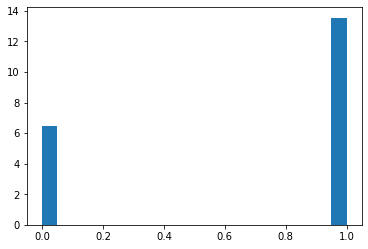

hook peak count accuracy 0.4142857142857143


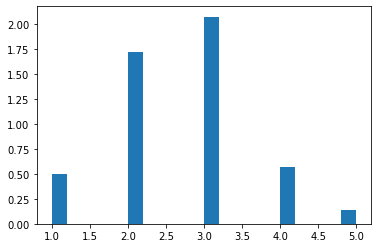

In [47]:
# # Sandbox for developing new features

import scipy.fftpack
import matplotlib.pyplot as plot

d = {'cross': [], 'hook': []}
for gesture in d.keys():
    for trace in traces[gesture]:
        normalized = min_max_scaler.fit_transform(trace['normalized_accel_z'].values.reshape(-1, 1))
        normalized = normalized[:, 0]
        normalized = normalized[0:len(normalized):5]
        normalized = np.diff((normalized > 0.77).astype(int))
        normalized = normalized[normalized>0]
        d[gesture].append(sum(normalized))

    viz = pd.Series(d[gesture])
    if gesture is 'cross':
        print('cross peak count accuracy', float(len(viz[viz == 2])) / len(viz))
    else: 
        print('hook peak count accuracy', float(len(viz[viz == 3])) / len(viz))
        
    plot.hist(d[gesture],density=1, bins=20) 
    plot.show()

In [48]:
# Feature Extraction

Y = GESTURES[:]
X = []
FEATURE_NAMES = []
AVG_X = []

for gesture in GESTURES:
    samples = []
    sum_samples = []
    for trace in traces[gesture]:
        if not FEATURE_NAMES:
            FEATURE_NAMES = get_all_features(trace, True)
    
        feature_values = get_all_features(trace)
        
        if not sum_samples:
            sum_samples = feature_values[:]
        else:
            sum_samples = [sum_samples[i] + feature_values[i] for i in range(len(feature_values))]
        samples.append(feature_values)
        
    AVG_X.append([x / float(len(traces[gesture])) for x in sum_samples])
    X.append(samples)

In [49]:
average_sample = pd.DataFrame(AVG_X, Y, columns=FEATURE_NAMES).transpose()
display(average_sample)
average_sample.iplot()

,cross,hook,negative_trim
max_accel,28772.737187,31475.568967,6894.072233
min_accel,1801.100689,2025.173567,2442.264408
range_accel,26971.636498,29450.395400,4451.807825
mean_accel,7122.707832,9772.419656,4345.929343
std_accel,4952.752451,8100.039122,1113.890180
max_gyro,15014.365741,12578.297798,3073.991639
min_gyro,165.504102,160.825315,253.135072
range_gyro,14848.861638,12417.472483,2820.856567
mean_gyro,3956.912561,3627.561382,1559.667696
std_gyro,4089.558988,3087.690234,683.895223


In [50]:
for gesture in GESTURES:
    print(gesture, len(traces[gesture]))
    
from sklearn.model_selection import train_test_split

# Flatten the data
X_flat = []
y_flat = []
for i in range(len(X)):
    X_flat += X[i]
    y_flat += [GESTURES[i]] * len(X[i])
X_flat = np.array(X_flat)
y_flat = np.array(y_flat)

# Generate pretty table of all for display
pretty_table = pd.DataFrame(X_flat, columns=FEATURE_NAMES)
pretty_table['y'] = pd.DataFrame(y_flat)
# display(pretty_table)

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_flat, test_size=0.33, random_state=42)
print(X_train.shape)
# print(y_train)
print(X_test.shape)
# print(y_test)

cross 90
hook 70
negative_trim 33
(129, 12)
(64, 12)


In [51]:
# Linear SVC Model

# Actually train the model
from sklearn import svm
from sklearn.metrics import confusion_matrix
model = svm.LinearSVC(max_iter=100000)
model.fit(X_train, y_train) 

# How did we do? 
print("Score:", model.score(X_test, y_test))
predictions = model.predict(X_test)
display(confusion_matrix(y_test, predictions))
df = pd.concat([pd.Series(predictions), pd.Series(y_test)], axis=1)
df.columns=["predicted", "actual"]
display(df)

# Save the model
import joblib
joblib.dump(model, 'models/' + str(len(X_flat)) + 'pt_model.joblib') 

Score: 1.0


array([[29,  0,  0],
       [ 0, 25,  0],
       [ 0,  0, 10]])

,predicted,actual
0,cross,cross
1,hook,hook
2,cross,cross
3,hook,hook
4,hook,hook
...,...,...
59,cross,cross
60,negative_trim,negative_trim
61,negative_trim,negative_trim
62,negative_trim,negative_trim


['models/193pt_model.joblib']